# 02.End-to-End-ML-Project

**1. Try a Support Vector Machine Regressor `sklearn.svm.SVR` with various hyper-parameters**
- `kernel="linear"` with various values for the `C` hyperparameter
- `kernel="rbf"` with various values for the `C` & `gamma` hyperparameters
- How does the best SVR predictor perform?

In [27]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("data", "01")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Creates `HOUSING_PATH`, Downloads & Extracts the contents of `HOUSING_URL` into `HOUSING_PATH`
    
    # Arguments:
        housing_url, string: the download link
        housing_path, string: where to download & extract data
    """
    os.makedirs(name=housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(url=housing_url, filename=tgz_path)
    housing_tgz = tarfile.open(name=tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    """Loads Housing data into a pandas dataframe.
    
    # Arguments:
        housing_path: the path where `housing.csv` exists
    
    # Returns:
        data, pd.DataFrame: the housing data as a pandas dataframe
    """
    data_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(data_path)
housing = load_housing_data()
housing['income_cat'] = pd.cut(x=housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X=housing, y=housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing.shape, housing_labels.shape

((16512, 10), (16512,))

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """Engineers new features from existing ones: `rooms_per_household`, `population_per_household`, `bedrooms_per_room`
    
    # Arguments:
        add_bedrooms_per_room, bool: defaults to True. Indicates if we want to add the feature `bedrooms_per_room`.
    """
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # We don't have any internal parameters. Only interested in transforming data.
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

housing_num = housing.drop("ocean_proximity", axis=1)
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr.shape

num_attribs = housing_num.columns.tolist()
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 17)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [32]:
param_grid = [
    {
        'kernel': ['linear'], 
        'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]
    },
    {
        'kernel': ['rbf'], 
        'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
        'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    }
]

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
svm_reg = SVR()
grid_search = GridSearchCV(estimator=svm_reg, param_grid=param_grid, cv=5, 
                           scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(X=housing_prepared, y=housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   5.6s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   5.5s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.4s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.2s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   4.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   4.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   7.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.2s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   6.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   7.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   6.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   6.6s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=   7.8s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

In [ ]:
best_mse = grid_search.best_score_
best_rmse = np.sqrt(-best_mse)
best_rmse

In [ ]:
grid_search.best_params_

- Note that the optimal value of `C` is at the maximum, naturally, you would want to launch a new grid search with even higher `C` values.
    - Removing smaller ones to preserve runtime.

**2. Try replacing `GridSearchCV` with `RandomizedSearchCV`**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon

params_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1)
}

svm_reg = SVR()
random_search = RandomizedSearchCV(estimator=svm_reg, param_distributions=params_distribs, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=2)
random_search.fit(X=housing_prepared, y=housing_labels)

In [ ]:
best_mse = random_search.best_score_
best_rmse = np.sqrt(-best_mse)
best_rmse

random_search.best_params_

- Randomized search tends to find better hyper-parameters than grid search in the same amount of time.
- The reciprocal distribution is useful when you have no idea what is the best hyper-parameter range.
- The exponential distribution is useful when you roughly know the range of optimal hyper-parameters.

**3. Try adding a transformer to the pipeline to select only the most important attributes**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])
arr = [-15, 30, 5, 89, -34, 15, 88]
indices_of_top_k(arr, 3)

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(arr=self.feature_importances, k=self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

- This implementation necessitate that you have feature importances before running the pipeline.
    - Probably getting from the base model.

In [2]:
k = 5

- Now let's create a pipeline that runs the previous pipeline and adds feature selection of the top k features:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

NameError: name 'Pipeline' is not defined

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X=housing)
housing_prepared_top_k_features[:3, :3]

**4. Try creating a single pipeline that does full data preparation + prediction**

- Using randomized search we found the optimal hyper-parameter setting, now we can just load a new model instance with the fine-tuned hyper-parameters
    - But the step of optimizing its **parameters** still needs to be done using `.fit()`

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('prediction', SVR(**random_search.best_params_))
])



prepare_select_and_predict_pipeline.fit(X=housing, y=housing_labels)

some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Targets:\t", some_labels.tolist())

**5. Automatically Explore some preparation options using `GridSearchCV`**

In [ ]:
param_grid = [
    {
        'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'feature_selection__k': list(range(1, len(feature_importances) + 1))
    }
]

grid_search_prep = GridSearchCV(estimator=prepare_select_and_predict_pipeline, param_grid=param_grid, 
                                cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search_prep.fit(X=housing, y=housing_labels)
grid_search_prep.best_params_
grid_search_prep.best_score_

# 03.Classification

**1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy over the test set.**

- KNeighbors classifier works well for this task.
- You just need to find good hyperparameter values
    - Try a grid search on `weights` and `n_neighbors` 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style()
from sklearn.datasets import openml

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
mnist = openml.fetch_openml(name='mnist_784', version=1)
X, y = mnist.data, mnist.target
X.shape, y.shape

X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=knn_clf, 
                         X=X_train, y=y_train, 
                         scoring='accuracy', cv=5)
scores

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5]
}

grid_search_clf = GridSearchCV(estimator=knn_clf, 
                               param_grid=grid, 
                               scoring='accuracy', 
                               cv=5, 
                               verbose=3)
grid_search_clf.fit(X=X_train, y=y_train)

In [ ]:
grid_search_clf.best_score_
grid_search_clf.best_params_

Let's train the model with the best parameters over the whole training set (without cross validation):

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_classifier.fit(X=X_train, y=y_train)
knn_classifier.score(X=X_test, y=y_test)

We got $97.14\%$ accuracy! Finally, Let's save the model:

**2. Write a function that can shift an MNIST image in any direction**

- Left/Right/Up/Down by 1 pixel.
- Then for each image in the training set, create 4 shifted copies
- Add the copies to the training set
- Finally, train your model on this training set and evaluate it on the test set
- This technique of expanding the training set is commonly referred to as *Data Augmentation* or *Training set expansion*

In [3]:
from scipy.ndimage.interpolation import shift
from sklearn.metrics import accuracy_score

def shift_digit(imgs, direction):
    """Shifts image by 1 pixel in any direction
    
    # Arguments
        imgs: np.ndarray, contains flattened digit images
        direction: string, direction you want to shift the pixels in. \in {'left', 'right', 'up', 'down'}
    
    # Returns
        shifted: np.ndarray, the resulting shifted image
    """
    dir_to_shift = {
        'up': [0, -1, 0],
        'down': [0, 1, 0],
        'left': [0, 0, -1],
        'right': [0, 0, 1]
    }
    return shift(imgs.reshape(-1, 28, 28), shift=dir_to_shift[direction], cval=0).reshape(-1, 28*28)

In [4]:
up_shifted_X_train = shift_digit(X_train, 'up')
down_shifted_X_train = shift_digit(X_train, 'down')
left_shifted_X_train = shift_digit(X_train, 'left')
right_shifted_X_train = shift_digit(X_train, 'right')

In [5]:
aug_X_train = np.concatenate((up_shifted_X_train, down_shifted_X_train, left_shifted_X_train, right_shifted_X_train), axis=0)
aug_X_train.shape

aug_y_train = np.concatenate((y_train, y_train, y_train, y_train), axis=0)
aug_y_train.shape

(240000,)

In [6]:
import random

def shuffle_X_y(X, y):
    """Shuffles two arrays using indexes
    
    # Arguments
        X: np.ndarray, input
        y: np.ndarray, output
    
    # Returns
        shuffled_X: np.ndarray
        shuffled_y: np.ndarray
    """
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    return X[indices], y[indices]

In [7]:
X_train.shape, aug_X_train.shape, y_train.shape, aug_y_train.shape

X_train = np.concatenate((X_train, aug_X_train), axis=0)
y_train = np.concatenate((y_train, aug_y_train), axis=0)
X_train.shape, y_train.shape

X_train, y_train = shuffle_X_y(X_train, y_train)

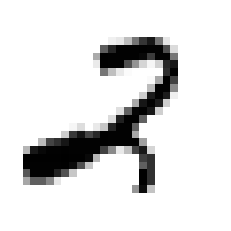

In [8]:
plt.imshow(X_train[99].reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

y_train[99]

knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn_classifier.fit(X=X_train, y=y_train)
y_hat = knn_classifier.predict(X=X_test)
accuracy_score(y_true=y_test, y_pred=y_hat)

We got $97.63\%$ test accuracy, $+0.5\%$ more than $97.14\%$ by using data augmentation!

---

# 04.Training-Models

**1. Which Linear Regression Algorithm can you use if you have a training set with millions of features?**

- Ordinary Linear Regression with Stochastic/Mini-Batch Gradient Descent as an optimizier and Lasso (for feature selection) as a regulalrizer.
    - the normal equation doesn't scale with the number of features.

**2. Suppose the features in your training set have very different scales, Which algorithms can suffer from this? and How? What can you do anout it?**

- Algorithms that **rely on distances** to optimize their parameters, like Linear regression with gradient descent.
- They suffer because the optimal optimization path is not straight because the feature scaling effects parameter scaling in the loss curve.
- The simple solution is to normalize/standarize all features to be in ranges such as $[0,1]$ $[-1,1]$ or using mean/standard diviation to center feature distributions around $0$ with $\sigma=1$.
- Note that the normal equation/SVD approach will work just fine without the need for feature scaling.
- Added to that the problem of regularizing a model with different feature scales is the possibility to convert to a suboptimal solution.

**3. Can gradient descent get stuck in a local minimum when training a logistic regression model?**

- No, because a logistic regression's loss function is convex.

**4. Do all gradient descent algorithms lead to the same model, provided you let them run long enough?**

- Only if we have these extra requirements:
    - the learning rate is small enough
    - The loss function is convex
- However, unless you gradually decrease the learning rate, stochastic/mini-batch gradient descent will never actually converge.
    - They keep trying to minimize for their current fed samples.

**5. Suppose you use batch gradient descent and you plot the validation error at each epoch. If you notice the validation error consistently goes up, What is Likely going on? How can you fix this?**

- Overfitting, It is when the model's sensitivity picks up on noise present in the training data.
- We can fix this by either setting an early stopping strategy where we stop training once the validation loss starts increasing and/or we regularize (constrain) the model to only capture global patterns.
- If the training loss is also going up then it's clear that the learning rate is too high and the model is diverging.

**6. Is it a good Idea to stop Mini-batch gradient descent immediately when the validation error goes up?**

- Because mini-batches sometimes do not represent the whole training set, we may witness an increase in validation loss but in general It's still decreasing.
    - So a good idea is to set a `patience` parameter, where you only stop after `parience` steps of increased validation loss. 
- A good strategy is to save the model each time you improve on the score (in intervals) than if the validation loss doesn't improve for `patience` steps, you stop and revert back to the lastest saved model.

**7. Which gradient descent algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?**

- Learning is based on the startegy (Batch, Stochastic, Mini-Batch), generally BGD is considered the best in terms of stability but it takes a long time to converge. Other alternatives are faster (SGD and MBGD) with Stochatic Gradient Descent being the fastest.
- Given the appropriate learning rate, all gradient-based algorithms on convex loss curves are guaranteed to converge.
- We implement a *learning rate schedule* startegy to ensure that optimization algorithms converge to the solution.
    - The most famous startegy is to incremently decrease the learning rate with each step, so an algorithm will start by making big jumps to quickly reach the optimum's region, then slows dows to converge to the actualy optimal point.

**8. Suppose you're using polynomial regression. You plot the learning curves and you notice a large gap between the training error and the validation error. What is hapenning? What are three ways to solve this?**

- If validation loss is far less than the training loss & the gap between them is large it mostly means that the validation data is not representative of the training data.
    - Solution — Properly shuffle/sample the validation set.
- If $loss(val)>>loss(train)$ It mostly means the model is overfitting to the training data, and there are several ways to deal with it:
    - Add more data to the corpus and resample.
    - Add more features.[x]
    - Constrain/Regularize the model.
        - When talking about a polynomial model, an example of constraining it is by decrease its degree.

**9. Suppose you used Ridge Regression and you noticed that the training error and validation error are almost equal and fairly high. Would you say the model suffers from high bias or high variance? should you increase the regularization hyper-parameter $\alpha$ or reduce it?**

- The model is typically underfitting, so it suffers from high-bias.
- We want a more complex model, so we reduce $\alpha$.

**10. Why would you like to use?**

- Ridge regression instead of plain linear regression without regularization?
    - If my model suffers from overfitting and I want to constraint it (high variance).
- Lasso instead of ridge regression?
    - If I have a lot of features and I'm interested in feature selection/importance.
- ElasticNet Instead of Lasso?
    - If I want to add a ridge regression component to the overall regularization part of the loss function, and Lasso didn't work for me.
    - Basically, If I want to keep lasso but without its erratic behavior.

**11. Suppose you have to classify pictures as Outdoors/Indoors and Daytime/Nighttime. Should you implement two Logistic regression classifiers or One softmax regression classifier?**

- Because a picture can be taken Indoor in Daytime (class probabilities don't sum up to $1$) we should use two Logistic regression classifiers.

**12. Implement Batch Gradient Descent with Early Stopping for Softmax Regression (Without the use of Scikit-Learn)**

Let's do it using the MNIST Dataset:

8


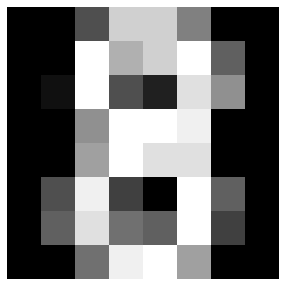

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = datasets.load_digits(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, 
                                                  random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape
plt.figure(figsize=(5,5))
plt.imshow(X_train[0].reshape(8,8), cmap='gray')
plt.axis('off')
print(y_train[0])

**1.Softmax Regression**

Let's start by creating the forward pass for softmax regression:

$$\hat{y}=\sigma(X\Theta)$$
$$\sigma(x_{i})=\frac{e^{x_{i}}}{\sum_{j=1}^{K}e^{x_j}}$$
$$X \in \Bbb{R}^{m \times (n+1)}, \Theta \in \Bbb{R}^{(n+1) \times K}$$
$$
X=
    \begin{pmatrix}
    1 & x_{1}^{(1)} & x_{2}^{(1)} & \dots & x_{n}^{(1)} \\
    1 & \dots & \dots & \dots & \dots \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    1 & x_{1}^{(m)} & x_{2}^{(m)} & \dots & x_{n}^{(m)} \\
    \end{pmatrix}
$$

In [13]:
import numpy as np
m, n = X_train.shape
K = len(set(y_train))
print(m, n, K)

X_train_ = np.concatenate((np.ones((m, 1)), X_train), axis=1)
X_train_.shape
X_val_ = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1)
X_val_.shape

1257 64 10


(540, 65)

In [14]:
W = np.random.rand(n+1, K)

In [15]:
def softmax(u):
    """Calculate the softmax vector using the input matrix
    
    # Arguments
        u: np.ndarray, input matrix of samples
    
    # Returns
        v: np.nadarray, softmaxed output matrix
    """
    return np.exp(u)/np.sum(np.exp(u), axis=1)[:,None]
def linear(X, W):
    """A Simple Linear Transformation
    """
    return np.matmul(X, W)

Let's make sure Linear & Softmax are correct by inspecting the sum of the probability distribution outputted by Softmax line-wise:

In [16]:
softmax(linear(X_train_, W)).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

**2. Batch Gradient Descent**

The loss is expressed as follows:

$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$$
$$\hat{p} \in \Bbb{R}^{m \times K}, y \in \Bbb{R}^{m \times K} (one-hot \space encoded \space from \space \Bbb{R}^{m \times 1})$$

& its gradient is:

$$\nabla_{\theta^{(k)}}J(\Theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}^{(i)}_{k}-y^{(i)}_{k})x^{(i)}$$

Let's implement it:

In [17]:
def cross_entropy(preds, targets):
    """Returns Cross Entropy Loss for Multi-class Classification"""
    
    m, K = preds.shape
    log_p = np.log(preds)
    y_logp = targets * log_p  # elementwise
    return (-1/m) * y_logp.sum(axis=1).sum()

def one_hot(u):
    m, K = u.shape[0], len(set(u))
    encoded = np.zeros((m, K))
    for i, u_i in enumerate(u):
        encoded[i][u_i] = 1
    return encoded

In [19]:
p_hat = softmax(linear(X_train_, W))
p_hat.shape, y_train.shape

cross_entropy(p_hat, one_hot(y_train))

27.653426091252054

Now let's implement $\nabla_{\Theta}J$ in its general form:

$$\nabla_{\Theta}J(\Theta) = \frac{1}{m}X^{T}(\hat{p}-y)$$

In [20]:
def grad_cross_entropy(inputs, preds, targets):
    """Calculate the gradient of the cross entropy loss function."""
    
    m, n = inputs.shape
    k = preds.shape[1]
    err = preds - targets
    return (1./m) * np.matmul(inputs.T, err)

In [21]:
X_train_.shape, p_hat.shape, one_hot(y_train).shape

((1257, 65), (1257, 10), (1257, 10))

In [22]:
grad_cross_entropy(X_train_, p_hat, one_hot(y_train)).shape

(65, 10)

**3. Early Stopping**

Finally, we implement a simple early stopping function to stop training when the validation loss stops decreasing:

In [23]:
def early_stop(val_losses):
    """Returns True if current_val_loss > prev_val_loss"""
    
    if len(val_losses) > 1:
        if val_losses[-1] > val_losses[-2]:
            return True
    return False

**4. Training Loop**

The Gradient Descent Algorithm is:

$$\Theta \leftarrow \Theta - \alpha \nabla_{\Theta}J(\Theta)$$

In [24]:
epochs, lr = 10000, 0.02
train_losses, val_losses = list(), list()
W = np.random.rand(n+1, K)

for epoch in range(epochs):
    # forward pass
    y_preds = softmax(linear(X_train_, W))
    
    # calculate train loss
    train_loss = cross_entropy(y_preds, one_hot(y_train))
    train_losses.append(train_loss)
    
    # calculate validation loss
    val_loss = cross_entropy(softmax(linear(X_val_, W)), one_hot(y_val))
    val_losses.append(val_loss)
    
    # Optimize parameters
    W = W - (lr * grad_cross_entropy(X_train_, y_preds, one_hot(y_train)))
    
    # early stop
    if early_stop(val_losses):
        break

Let's plot the training vs. validation losses:

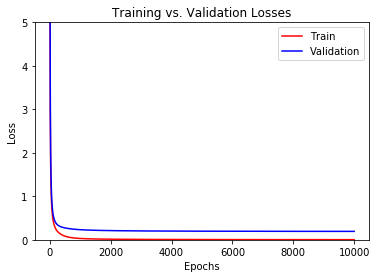

In [27]:
plt.plot(range(len(train_losses)), train_losses, color='red', label='Train')
plt.plot(range(len(val_losses)), val_losses, color='blue', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.title('Training vs. Validation Losses')
plt.show()

Let's check our accuracy over the validation set:

In [28]:
val_preds = np.argmax(softmax(linear(X_val_, W)), axis=1)
acc = ((val_preds == y_val).sum())/len(val_preds)
acc

0.9648148148148148

# 05.SVMs

**1. What is the Fundamental Idea Behind Support Vector Machines**

- For classification, The premise of SVMs is finding decision boundaries that maximize relative distance between them and points and minimize the number of violations in the supporting street.
- For regression, the opposite is true, SVMs optimize for a street the is as close as possible to the training instances, hence maximizing the number of violations to it.

**2. What is a Support Vector**

- A Support vector represents the training instance that is used to create a boundary of the street, hence it's considered a "support" for it.
- Any instance that is not a support vector has no influence whatsoever on the decision boundary.

**3. Why is It Important to Scale the Input when using SVMs**

- A proparly scaled feature space will create empty space for the SVM model to be optimized to split it.
- If the feature space is not scaled, the algorithm will tend to ignore features with small scales.

**4. Can an SVM classifier output a confidence score when it classifies an instance? How about a probability?**

- SVM model can output confidence scores based on the distance from the instance to the decision boundary.
- SVMs can't really output a probability score.
    - But you could estimate it using sklearn's hyper-parameters.

**5. Should You Use the Primal or the Dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?**

- It's better to use the Primal form of the SVM problem because the Dual form is only faster when the number of features is more than the number of instances.

**6. Say you've trained an SVM classifier with the RBF Kernel, but it seems to underfit the training data, should you increase or decrease $\gamma$? How about $C$?**

- Increasing $\gamma$ and $C$ is good because it will increase model sensitivity.

**7. How you should set the QP parameters ($H$, $f$, $A$, and $b$) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?**

- The general formulation of a quadratic programming problem is as follows:

$$\begin{array}{ll}
\text{minimize}_{p} & \frac{1}{2}p^THp + f^Tp \\
\text{subject to} & Ap \le b
\end{array}$$

- Where:

$$\begin{cases}
p \in \Bbb{R}^{n_p \times 1} \qquad n_p: parameter \space count \\
H \in \Bbb{R}^{n_p \times n_p} \\
f \in \Bbb{R}^{n_p \times 1} \\
A \in \Bbb{R}^{n_c \times n_p} \qquad n_c: constraints \space count \\
\end{cases}$$

- Let's consider $H'$, $f'$, $A'$ and $b'$. The parameters for the soft margin SVM problem form are:

$$f=[f' \underbrace{C\cdots C}_{m\text{ times}}] \\ b=[b' \quad \underbrace{0\cdots 0}_{m\text{ times}}] \\ p=[\underbrace{w}_{n+1 \text{ times}} \quad \underbrace{\zeta}_{m \text{ times}}] \\ A=\begin{pmatrix} A' & I_m \\ 0 & -I_m \end{pmatrix} \\ H=\begin{pmatrix} H' & 0 \\ 0 & 0 \end{pmatrix} $$

**8. Train a `LinearSVC` on a Linearly Separable Dataset. Then train an `SVC` & a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model**

In [59]:
from sklearn.svm import LinearSVC, SVC 
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

Let's first generate linearly separable data:

In [60]:
d1 = np.concatenate((np.random.normal(loc=6, scale=1, size=(500, 2)), np.ones((500, 1))), axis=1) 
d2 = np.concatenate((np.random.normal(loc=3, scale=1, size=(500, 2)), np.zeros((500, 1))), axis=1) 
d1.shape, d2.shape

((500, 3), (500, 3))

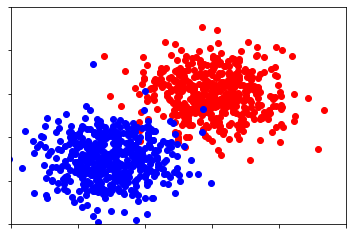

In [61]:
plt.scatter(d1[:,0], d1[:,1], c='red')
plt.scatter(d2[:,0], d2[:,1], c='blue')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic 2D Points')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

Next, we combine and shuffle the data:

In [64]:
d = np.concatenate((d1, d2), axis=0)
print(d.shape)

np.random.shuffle(d)

(1000, 3)


Time for training:

In [66]:
model = LinearSVC()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(d[:,:2], d[:,2:], test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 1), (200, 1))

In [69]:
model.fit(X_train, y_train.ravel())
model.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.99

Let's plot its decision boundary:

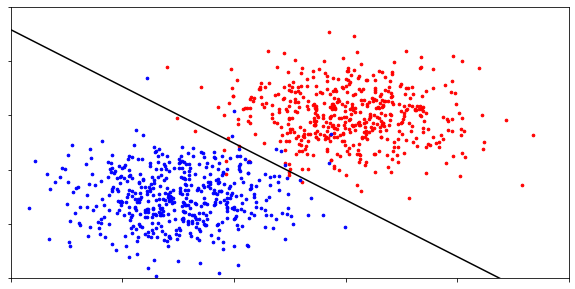

In [73]:
plt.figure(figsize=(10,5))
# Points
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)
# Decision boundaries
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 10)
yy = a * xx - (model.intercept_[0]) / w[1]
plt.plot(xx, yy, 'k-')
# Other
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic 2D Points')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

Next, let's try `SVC` & contrain it to approximate the linear classifier:

In [75]:
C = 99.
svc_clf = SVC(C=C, kernel='linear', degree=1, gamma='auto')
svc_clf.fit(X_train, y_train.ravel())

svc_clf.score(X_test, y_test)

0.99

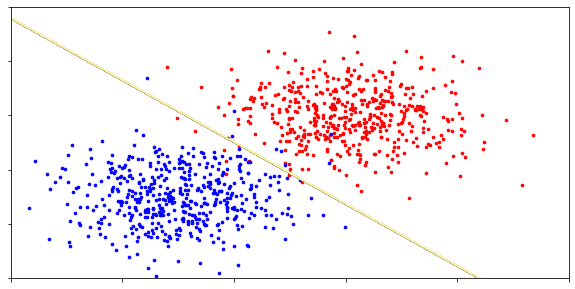

In [77]:
h = .02 
x_min, x_max = d[:,0].min() - 1, d[:,0].max() + 1
y_min, y_max = d[:,1].min() - 1, d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,5))
# Points
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)
# Decision boundary
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
# Other
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic 2D Points')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

To have a similar classifier, we needed to specify the kernel parameter as `linear` and the degree parameter as $1$.

Finally, let's try to do the same to `SGDClassifier`:

In [80]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train.ravel())
sgd_clf.score(X_test, y_test)

0.975

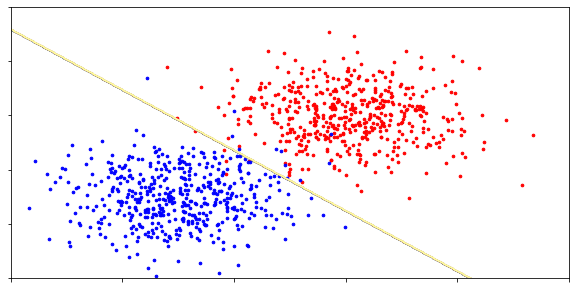

In [82]:
h = .02 
x_min, x_max = d[:,0].min() - 1, d[:,0].max() + 1
y_min, y_max = d[:,1].min() - 1, d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = sgd_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,5))
# Points
plt.scatter(d1[:,0], d1[:,1], c='red', s=7)
plt.scatter(d2[:,0], d2[:,1], c='blue', s=7)
# Decision boundary
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
# Other
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic 2D Points')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

`SGDClassifier`s are just regular **linear** classifiers trained using Stochastic Gradient Descent, so we get what we want without regularization.

**9. Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-rest to classify all 10 digits. You may want to tune the hyper-parameters using small validation sets to speed up the process. What accuracy can you reach?**

In [85]:
from sklearn import datasets

X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46900, 784), (23100, 784), (46900,), (23100,))

We will use cross-validation to optimize hyper-parameters:

In [86]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

clf = OneVsRestClassifier(estimator=SVC(gamma='auto'))
scores = cross_val_score(estimator=clf, 
                         X=X_train[:1000]/255., 
                         y=y_train[:1000], cv=7)
print(f"We reach an accuracy of {sum(scores)/len(scores)}")

We reach an accuracy of 0.8023151586087148


**10. Train an SVM Regressor on the California Housing Dataset**

In [87]:
from sklearn.svm import SVR
X, y = datasets.california_housing.fetch_california_housing(return_X_y=True)
X.shape, y.shape
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

First we scale:

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
regressor = SVR()
regressor.fit(X_train, y_train)
regressor.score(scaler.transform(X_val), y_val)

0.7249763453746596

# 06.Decision_Trees

**1. What is the approximate depth of a decision tree trained without restrictions on a training set with 1 million instances?**

- If the tree is balanced, then at every layer it splits the samples in two, so the depth is $log_{2}(1\,000\,000) \approx 20$.
    - Acutally a bit more since the tree won't be perfectly balanced.

**2. Is a node's Gini impurity generally lower or greater than its parent's? Always Lower/greater?**

- Gini's impurity score is generally lower than its parent.
- However, it is possible for a child node to have higher Gini's score as long as it's compensated by its other binary node and by the weights of its sample size.

**3. If a decision tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?**

- Yes, It's a good idea since you're contraining the model's predictions to bigger `sample_size` averages.

**4. If a decision tree is underfitting the training set, is it a good idea to try scaling the input features?**

- Decision Trees **don't need feature scaling** for them to work, you can reduce underfitting by increasing `max_depth`, decreasing `min_leaf_samples` or any of the other regularization hyper-parameters.

**5. If it takes one hour to train a decision tree on a training set containing one million instances, roughly how much time it would take it on a 10M training set?**

- $11.66$hours.

**6. If your training set contains 100K instances, will setting `presort=True` speedup training?**

- No, sorting data will only boost performance when you have instance on the scale of less than a few thousands.

**7. Train & Fine-tune a decision tree for the moons dataset by following these steps:**

a. Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset 

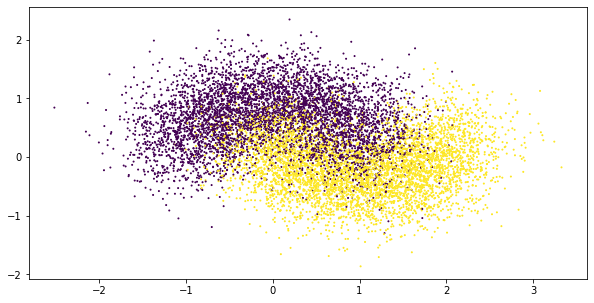

In [5]:
import sklearn
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.4)
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
plt.show()

b. Use `train_test_split()` to split the data into a training set and a test test:

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 2), (7000,), (3000, 2), (3000,))

c. Use grid search with cross validation (with the help of the `GridSearchCV`) to find good hyper-parameter values for a `DecisionTreeClassifier`

*Hint: Try various values for `max_leaf_nodes`*

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier()
param_grid = {
    'max_leaf_nodes': [3, 4, 5, 6, 7]
}
grid_searcher = GridSearchCV(estimator=clf, 
                             param_grid=param_grid)
grid_searcher.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': [3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=F

In [23]:
print(grid_searcher.best_score_, grid_searcher.best_params_)

0.8484285714285714 {'max_leaf_nodes': 4}


**8. Grow a Forest by following these steps**

a. Continuing the previous exercice, generate a 1,000 subsets of the training set, each containing a 100 instances selected randomly. 

*Hint: you can use scikit-learn's `ShuffleSplit` class for this*

In [32]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1000, train_size=100)

b. Train one decision tree on each subset, using the best hyper-parameter values found in the previous exercice. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only aboyt 80% accuracy.

In [33]:
decision_trees = list()
ds_test_scores = list()

for train_idxs, _ in rs.split(X_train, y_train):
    
    # get sample
    x_bs = X_train[train_idxs]
    y_bs = y_train[train_idxs]
    
    # train decision tree
    clf = DecisionTreeClassifier(max_leaf_nodes=4)
    clf.fit(x_bs, y_bs)
    decision_trees.append(clf)
    
    # evaluate decision tree
    ds_test_scores.append(clf.score(X_test, y_test))
    
    # delete model
    del(clf)

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction. This approach gives you *majority-vote* predictions over the test set.

In [57]:
from scipy.stats import mode
import numpy as np
all_preds = list()
for tree in decision_trees:
    all_preds.append(tree.predict(X_test).tolist())

trees_preds = np.array(all_preds)
trees_preds.shape

preds, _ = mode(trees_preds, axis=0)

print(trees_preds.shape)

(1000, 3000)


d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5% to 1.5% higher).

*Congratulations, You have trained a random forest classifier!*

In [58]:
sum(preds.squeeze() == y_test)/len(y_test)

0.8523333333333334

# 07.Ensembles_RFs

**1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, How? If not, Why?**

- Yes, we can combine their predictions:
    - Classification Problems
        - hard voting (y_hat=mode(preds))
        - soft voting for classification (averaging estimated class probabilities and taking the class associated with the highest one).
    - Regression Problems
        - Taking the mean of the predicted values from each model.

**2. What is the difference between hard & soft voting classifiers?**
- Hard voting: we take all of the predictions and output the mode (the most frequently predicted class).
- Soft voting: we average all probabilities associated with each class and output the class with the highest averaged probability.

**3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles? Boosting ensembles, random forests, stacking ensembles?**

- Bagging Ensemble (Bootstrap Aggregation — Sampling with replacement + feature subsetting): It is parallelizable.
- Pasting Ensemble (Only difference — Sampling without replacement): It is parallelizable.
- Boosting Ensemble (Trains predictors sequentially): Not parallelizable.
- Random Forests: Parallelizable.
- Stacking Ensemble: Stacking is partly parallelizable, we can train massive predictors in the first layer but we have to wait for the ith training phase to finish before training subsequent layers (and the final blender).

**4. What is the benefit of out-of-bag evaluation?**

- We don't need a hold-out set and we evaluate each individual predictor on the fly and export and estimate of the overall performance of the ensemble model.

**5. What makes Extra-Trees more random than regular random forests? How can this extra randomness help? Are extra trees slower or faster than regular random forests?**

- Extra-Trees are more random than regular random forests in that they choose a subset of features to select from at each split and they don't necessary choose the best threshold but they take random thresholds.
- This added randomness helps in creating much more varied trees and helps in training a good model.
- Extra-trees are faster then regular random forests because they don't have to check for the best split on all features and thresholds.
    - But extra-trees aren't faster then random forests in inference time.

**6. If your Adaboost ensemble underfits the training data, which hyper-parameters should you tweak and how?**

- Increase the number of estimators and reducring the the regularization hyper-parameters for teh base estimator.
- Increasing the learning rate.
- We should decrease $\eta$ so that weights are not extreme.

**7. If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?** 

- We should decrease the learning rate because it shrinks the contribution of each tree.

**8. Load MNIST data, and split it into a training set, a validation set, and a test set (Use 50k instances for training, 10k for validation, and 10k for testing)**

In [66]:
X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X.shape, y.shape

((70000, 784), (70000,))

Let's shuffle and sample:

In [67]:
random_indices = np.random.permutation(X.shape[0])

X = X[random_indices]
y = y[random_indices]

We verify that it's fine:

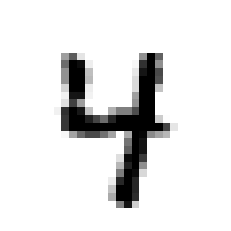

In [68]:
plt.imshow(X[33].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

In [69]:
y[33]

'4'

Let's split it:

In [70]:
X_train, y_train = X[:50000], y[:50000]
X_val, y_val = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:], y[60000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

I don't have enough compute power, let's take 10% of each dataset:

In [71]:
X_train, y_train = X_train[:5000], y_train[:5000]
X_val, y_val = X_val[:1000], y_val[:1000]
X_test, y_test = X_test[:1000], y_test[:1000]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5000, 784), (5000,), (1000, 784), (1000,), (1000, 784), (1000,))

**Train a Random Forests Classifier, an Extra-Trees classifier, & an SVM classifier**

In [74]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc

rfc = RandomForestClassifier(n_estimators=10)
etc = ExtraTreesClassifier(n_estimators=10)
svc = SVC(probability=True)

rfc.fit(X_train, y_train)
etc.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc(y_val, rfc.predict(X_val)), acc(y_val, etc.predict(X_val)), acc(y_val, svc.predict(X_val))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(0.876, 0.885, 0.126)

**Try to combine them into an `ensemble that outperforms` each individual classifier on the validation set, using soft or hard voting**

In [ ]:
from sklearn.ensemble import VotingClassifier

hard_voter = VotingClassifier(estimators=[('random forest', rfc), 
                                          ('extra trees', etc), 
                                          ('support vector classifier', svc)], 
                              n_jobs=-1)
hard_voter.fit(X_train, y_train)
acc(y_val, hard_voter.predict(X_val))

In [ ]:
soft_voter = VotingClassifier(estimators=[('random forest', rfc), 
                                          ('extra trees', etc), 
                                          ('support vector classifier', svc)],
                              voting='soft',
                              n_jobs=-1)
soft_voter.fit(X_train, y_train)
acc(y_val, soft_voter.predict(X_val))

**Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?**

In [79]:
acc(y_test, rfc.predict(X_test)), acc(y_val, etc.predict(X_val)), acc(y_test, svc.predict(X_test))

(0.892, 0.885, 0.11)

In [ ]:
acc(y_test, hard_voter.predict(X_test))
acc(y_test, soft_voter.predict(X_test))

In [80]:
etc_preds = etc.predict(X_val)[..., None]
rfc_preds = rfc.predict(X_val)[..., None]
svc_preds = svc.predict(X_val)[..., None]
etc_preds.shape, rfc_preds.shape, svc_preds.shape

((1000, 1), (1000, 1), (1000, 1))

**9. Run the previous classifiers from the previous exercice to make predictions on the validation set, and create a new training set with the resulting predictions**

In [83]:
X_val_ = np.concatenate((etc_preds, rfc_preds, etc_preds), axis=1)
print(X_val_.shape, y_val.shape)
rfc_ = RandomForestClassifier(n_estimators=10)
rfc_.fit(X_val_, y_val)

(1000, 3) (1000,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble!**

**Now evaluate the ensemble on the test set.**
1. For each image in the test set, make predictions with all your classifiers
2. feed the predictions to the blender to get the ensemble’s predictions.
3. How does it compare to the voting classifier you trained earlier?

In [84]:
etc_preds = etc.predict(X_test)[..., None]
rfc_preds = rfc.predict(X_test)[..., None]
svc_preds = svc.predict(X_test)[..., None]

In [85]:
X_test_ = np.concatenate((etc_preds, rfc_preds, etc_preds), axis=1)
y_test_ = rfc_.predict(X_test_)
acc(y_test, y_test_)

0.908

It does better than the hard voter and worse then the softvoter.

# 08.Dim_Reduction

**1. What are the main motivations for reducing a Dataset's dimensionality? What are the main Drawbacks?**

- Motivations: 
    - We can **visualize** the data in 2D/3D spaces. 
    - We want to **reduce the dimensionality** of big datasets that we suspect have static or very noisy features, so reduction will be a preprocessing step to then train the reduced dataset for the final task, meaning faster training.
    - Data **compression**.
- Drawbacks: By reducing the dimensionality of the dataset .. 
    - We typically **lose some useful information** in the process even though we try to preserve as much as possible.
    - the resulting trained **classifier will typically be weaker** than a classifier trained on the original dataset.
    - It can be **computationally expensive** (depending on the algorithm, the features and the size of the dataset).
    - It **adds complexity** to the overall machine learning pipeline.
    - Transformed features are often **hard to interpret**.

**2. What is the curse of dimensionality?**

- As we increase the number of dimensions (or features) the average distance between any two instances tend to increase as well, in other words, in high-dimensional spaces, instances tend to sit on the edges of the space. This leads to training problems since no clusters/trends are apparent in a space filled with void and the algorithm would need more data to learn. 

**3. Once a Dataset's dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?**

- It depends on the algorithm used to reduce the dimensionality of the data, in the case of PCA, we can recover most of the information using the following formula:

$$X_{\text{recovered}}=X_{\text{d-proj}}W_{d}^{T}$$

- For manifold learning, if using the kernels for example, we can't really reverse the operation since we first project into an infinite-dimensional space. But we can approximate a reverse operation by distance.

**4. Can PCA be used to reduce the dimensionality of a highly non-linear dataset?**

- Generally speaking, when we have a dataset with many useless features, reducing it is possible while preserving information, but if the features of the data are important, as in the case of the data sitting in a manifold, compressing it with **PCA would lose too much information**.

**5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?**

- We can't really know without optimizing for retaining 95% variance within the data.
- If all of the variance occur on one dimension, then the resulting will have a dimensionality of 1.
    - Else, it will necessarily increase the number of dimensions.

**6. In What cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?**

- Vanilla PCA: for static data analysis where you have a static dataset and you want to perform a one-time dimensionality reduction for the purposes of data analysis.
- Incremental PCA: 
    - The first use case is when having a large dataset that can't be fit into memory at once. 
    - The second is when you're in an online setup where instances/batches are coming in intervals.
- Randomized PCA: When speed and performance are important we use randomized PCA for its faster search algorithm.
- Kernel PCA: If I know that my high-dimensional instances form clusters and I want to preserve that after projection. 

**7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?**

- By measuring the reconstruction loss, meaning the distance betweeen the original dataset and the compressed then reconstructed dataset using a particular algorithm. 
    - When the trained algorithms don't offer a reconstruction mechanism, we can simply evaluate their performance by comparing the end metric while freezing the subsequent steps in the pipeline, for example if we're doing dimensionality reduction then classification, we would fix the algorithm/hyperparameters of the ML step and vary the dimensionality reduction algorithm and take the classification accuracy as a metric to evaluate different dimensionality reduction algorithms.

**8. Does it make any sense to chain two different dimensionality reduction algorithms?**

- It may make sense if algorithm A is good for high to low dim reduction then another algorithm is good for low-dim to d-dim cluster-preserving reduction. 
- Or Algorithm B is better then A but much slower, so we use A to get rid of most useless features then B to maximize performance.

**9. Load the MNIST dataset & split it into train/test sets**

In [43]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

**Train a random forest classifier on the dataset and time how long it takes**

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)
%timeit -n1 -r1 forest.fit(X_train, y_train)

39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**Then evaluate the resulting model on the test set**

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, forest.predict(X_test))

0.9711

**Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%**

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

**Train a random forest classifier on the reduced dataset and see how long it takes. Was training much faster?**

In [48]:
forest = RandomForestClassifier(n_estimators=100)
%timeit -n1 -r1 forest.fit(X_train, y_train)

1min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- It was about x2.25 **slower** (Prob for not having the time to run multiple performance loops).

**Next, evaluate the classifier on the test set. How does it compare to the previous classifier?**

In [51]:
accuracy_score(y_test, forest.predict(X_test))  # expected.

0.9464

**10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using `matplotlib`**

In [52]:
from sklearn.manifold import TSNE

from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

tsne = TSNE()
X_train = tsne.fit_transform(X_train[:1000])

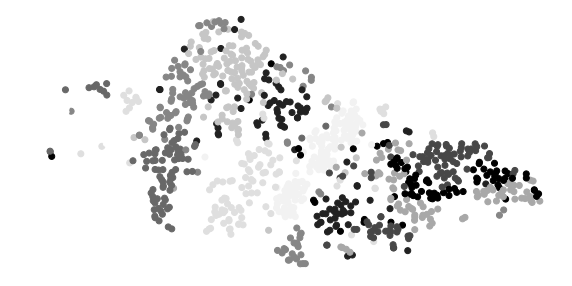

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(X_train[:,0], X_train[:,1],
            c=y_train[:1000].astype(int),
            cmap='Greys')
plt.axis('off')
plt.show()

**You can replace each dot with its corresponding instance class** (from 0 to 9)

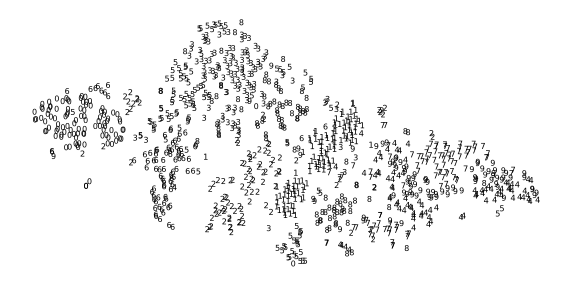

In [59]:
plt.figure(figsize=(10, 5))
labels = y_train[:1000].astype(int)
for idx in range(len(X_train)):
    plt.scatter(X_train[idx,0], X_train[idx,1], 
                marker=f"$ {labels[idx]} $", 
                c='black', edgecolors='none')
plt.axis('off')
plt.show()

**Even plot scaled-down versions of the digit images themselves** (make sure to only visualize a sample)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

tsne = TSNE()

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X_train[:, 0], X_train[:,1])

for idx in range(len(X_train)):
    ab = AnnotationBbox(OffsetImage(X_train[idx].reshape(28, 28), zoom=0.7), 
                        (X_train[idx, 0], X_train[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.show()

**Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS & compare the resulting visualization**

In [ ]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2)
X_train_ = pca.fit_transform(X_train[:1000])

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_train_[:, 0], X_train_[:,1])

for idx in range(len(X_train_)):
    ab = AnnotationBbox(OffsetImage(X_train[idx].reshape(28, 28), zoom=0.7), (X_train_[idx, 0], X_train_[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()

- We notice clusters especially with `1`s and `0`s but its clustering isn't as good as `TSNE`.

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_train_ = lle.fit_transform(X_train[:1000])
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_train_[:, 0], X_train_[:,1])

for idx in range(len(X_train_)):
    ab = AnnotationBbox(OffsetImage(X_train[idx].reshape(28, 28), zoom=0.7), (X_train_[idx, 0], X_train_[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()

- It seems that `TSNE` produces the best interpretable visualizations.

# 09.Unsupervised_Learning

**1. How would you define clustering? Can you name a few clustering algorithms?**
- Clustering is the process of uncovering groups (or clusters) within unlabaeled data instances.
    - It may use distance or density measures.
- Algorithms: `KMeans`, `DBSCAN`, `GMMs`, ...

**2. What are some of the main applications of clustering algorithms?**
- Customer Segmentation
- Fraud Detection
- Novelty Detection
- Social Networks Analysis (Communities)
- Data analysis/visualization
- Dimensionality reduction

**3. Describe 2 techniques to select the right number of clusters when using K-Means?**
- Plotting the [`silouhette`](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) density score in relation to the chosen number of clusters then choosing the number of clusters that maximizes the score.
- The `Elbow rule`: By choosing the number of clusters that decreased the inretia the most.

**4. What is label propagation? Why would you implement it? and How?**
- Label propagation is useful in the context of semi-supervised learning where we have few labeled points and a lot of unlabeled instances and we want to propagate the labels from the annotated samples to the unlabeled ones.
- We would want to to implement it if we have a downstream supervised learning task that needs more data.
- A simple strategy would be distance-based propagation, where first we will train an algorithm to do unsupervised clustering and then propagate the labels into the ones that correspond to the same clusters of the annotated instances.

**5. Can you name two clustering algorithms that can scale to large datasets? and two that look for regions of high density?**

- Scale to large datasets: `DBSCAN` (if $\epsilon$ is small enough), and `KMeans` (if dataset is comprised of clusters), and `BIRCH`.
- Look for regions of high density: `DBSCAN` and `MeanShift`.

**6. Can you think of a use case when active learning would be useful? How would you implement it?**

- It would be useful when we're having a small labeled dataset and a lot of unlabeled instances.
- First we train the algorithm of the available labeled instances. Then we predict on the unlabeled instances and give the annotator the instances that the algorithm isn't sure about. We loop until the increase in performance in not noticeable anymore.
    - Called **uncertainty sampling**.

**7. What is the difference between Anomaly Detection & Novelty Detection?**

- Anomaly Detection: Detecting instances that **don't belong** to the same data distribution of the training data.
- Novelty Detection: Detecting instances that **look extreme but belong to** the same distribution of the training data.

**8. What is a Gaussian Mixture? What Tasks can you use it for?**

- Gaussian Mixture is a probabilistic model comprised of multiple gaussian distributions with multiple parameters ($\mu$ and $\sigma$) and a set of weights ($\phi$) that describe the probability that an instance belongs to one of the distributions.
- In our case, it was used to uncover clusters in unlabeled data assuming that all of the clusters correspond to gaussian distributions.

**9. Can you find two techniques to find the right number of clusters when using a Gaussian mixture model?**

- Plotting the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC) as a function of the number of clusters then chose the number that minimizes either.
- Using Bayesian Gaussian Mixture Models to avoid random search and using priors instead.

**10. The classic Olivetti faces dataset contains 400 gray-scale $64 \times 64$-pixel images of faces. Each image is flattened to a 1D vector of size $4,096$. 40 different people were photographed (10 times each), and the usual task is to train a model to predict which person is represented in each picture. Load the dataset using `sklearn.datasets.fetch_olivetti_faces()` function, then split it into training/validation and test set. Since the dataset is quite small, you probability want to use stratefied sampling to ensure that there are the same number of images per person in each set** 

In [2]:
from sklearn import datasets
of = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/awang/scikit_learn_data


In [5]:
X, y = of.data, of.target
X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((225, 4096), (225,), (75, 4096), (75,), (100, 4096), (100,))

**Cluster the images using `KMeans`, and measure that you have a good number of clusters. Visualize the clusters: do you see similar faces in each cluster?**

In [ ]:
from sklearn.cluster import KMeans
kms = KMeans()
kms.fit(X_train)

inretias = list()
for k in range(1, 20):
    kms = KMeans(n_clusters=k)
    kms.fit(X_train)
    inretias.append(kms.inertia_)

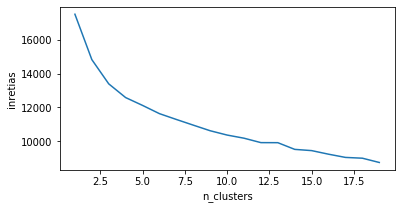

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(range(1, 20), inretias)
plt.xlabel('n_clusters')
plt.ylabel('inretias')
plt.show()

- Based on the figure we choose `5` as the number of clusters.

**Visualize the clusters: Do you see similar faces in each cluster?**

- Yes, let's perform TSNE and visualize the images:

t-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_train_reduced = tsne.fit_transform(X_train)
X_train_reduced.shape

(225, 2)

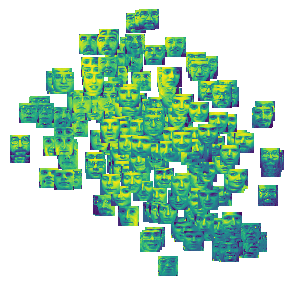

In [22]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:,1])

for idx in range(len(X_train_reduced)):
    ab = AnnotationBbox(OffsetImage(X_train[idx].reshape(64, 64), 
                                    zoom=0.3), 
                        (X_train_reduced[idx, 0], 
                         X_train_reduced[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()

**11. Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture and evaluate it on the validation set** 

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.96

**Next, use `KMeans` as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: What performance can you reach?**

- Around 25 cluster gives us a 68% accuracy.

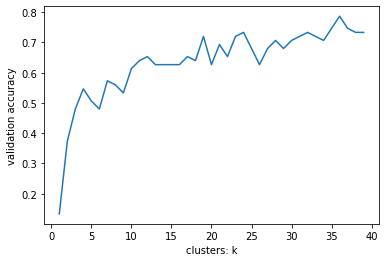

In [31]:
clusters, val_accs = [], []

for k in range(1, 40):
    kms = KMeans(n_clusters=k).fit(X_train)
    X_train_tmp = kms.transform(X_train)
    X_val_tmp = kms.transform(X_val)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_tmp, y_train)
    clusters.append(k)
    val_accs.append(rf.score(X_val_tmp, y_val))

plt.plot(clusters, val_accs)
plt.xlabel('clusters: k')
plt.ylabel('validation accuracy')
plt.show()

**What if you append the features from the reduced set to the original features?**

- 26 to 32 seems good (but we need bigger validation sets) with >= 91% accuracy.

In [33]:
import numpy as np
clusters, val_accs = list(), list()

for k in range(1, 40):
    kms = KMeans(n_clusters=k).fit(X_train)
    X_train_tmp = np.concatenate((X_train, kms.transform(X_train)), axis=1)
    X_val_tmp = np.concatenate((X_val, kms.transform(X_val)), axis=1)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_tmp, y_train)
    clusters.append(k)
    val_accs.append(rf.score(X_val_tmp, y_val))

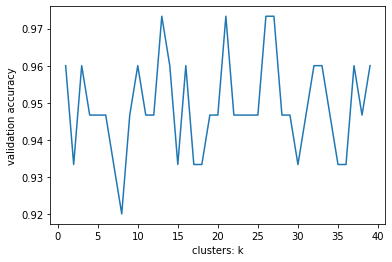

In [34]:
plt.plot(clusters, val_accs)
plt.xlabel('clusters: k')
plt.ylabel('validation accuracy')
plt.show()

**12. Train a Gaussian Mixture Model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (Use PCA, preserving 99% of the variance)**

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train)

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=25)
gm.fit(X_train_reduced)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=25, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

**Use the model to generate some new faces and visualize them**

In [41]:
generated_samples, _ = gm.sample(n_samples=100)
generated_faces = pca.inverse_transform(generated_samples)
generated_faces.shape

(100, 4096)

In [42]:
tsne = TSNE()
generated_faces_reduced = tsne.fit_transform(generated_faces)
generated_faces_reduced.shape

(100, 2)

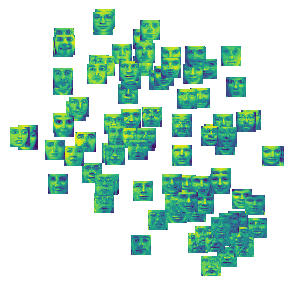

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(generated_faces_reduced[:, 0], generated_faces_reduced[:,1])

for idx in range(len(generated_faces)):
    ab = AnnotationBbox(OffsetImage(generated_faces[idx].reshape(64, 64), 
                                    zoom=0.3), 
                        (generated_faces_reduced[idx, 0], 
                        generated_faces_reduced[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()